In [3]:
# lunar lander with DQN
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env

# https://huggingface.co/learn/deep-rl-course/unit1/hands-on?fw=pt
from stable_baselines3 import PPO, A2C, DQN

# set up the environment
vec_env = make_vec_env("LunarLander-v2", n_envs=38)
eval_env = gym.make("LunarLander-v2", render_mode='rgb_array')

In [40]:

model_PPO = PPO(
    policy="MlpPolicy",
    env=vec_env,
    n_steps=1024,
    batch_size=64,
    n_epochs=4,
    gamma=0.999,
    gae_lambda=0.98,
    ent_coef=0.01,
    verbose=1,
    device='mps'
)

model_PPO.learn(total_timesteps=100_000)
model_PPO.save("models/ppo_lunarlander")


Using mps device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.4     |
|    ep_rew_mean     | -180     |
| time/              |          |
|    fps             | 4951     |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 38912    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 89.7        |
|    ep_rew_mean          | -138        |
| time/                   |             |
|    fps                  | 1562        |
|    iterations           | 2           |
|    time_elapsed         | 49          |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.008028228 |
|    clip_fraction        | 0.0702      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.0022      |
|    learning

In [37]:

model_A2C = A2C(
    policy="MlpPolicy",
    env=vec_env,
    n_steps=512, # number of steps to unroll for each environment
    gamma=0.99, # discount factor, higher means more focus on the future
    gae_lambda=0.99, # higher means more focus on the future
    ent_coef=0.05, # entropy coefficient, higher means more exploration
    verbose=1,
    device='mps'

    )
    
model_A2C.learn(total_timesteps=3_00_000)
model_A2C.save("models/a2c_lunarlander")

# close progress_bar



Using mps device


n_steps: 100, mean reward: -785.5226651314771, std: 376.93546818350075
n_steps: 278, mean reward: -824.138946514197, std: 414.44373985763775
n_steps: 774, mean reward: -157.39390775594572, std: 97.10359090421797
n_steps: 2154, mean reward: -107.71606436596689, std: 146.36559456858168
n_steps: 5994, mean reward: -74.59954214426843, std: 106.63105087307108
n_steps: 16681, mean reward: -315.03181515014586, std: 151.73284361273207
n_steps: 46415, mean reward: -65.99638737125161, std: 151.0927264161285
n_steps: 129154, mean reward: -60.006958909080716, std: 157.6791665890884
n_steps: 359381, mean reward: -27.250454157928797, std: 161.46480536621888
n_steps: 1000000, mean reward: 31.69607653919947, std: 178.19393473213574


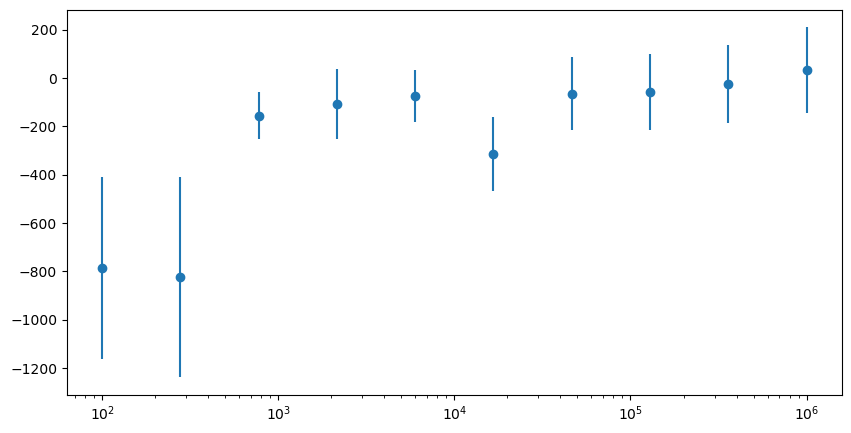

In [28]:

results = {}
for n_steps in np.logspace(2, 6, 10, dtype=int):

    model_DQN = DQN(
        policy="MlpPolicy",
        env=vec_env,
        learning_rate=1e-2, # control the learning rate
        buffer_size=10_000, # control the size of the replay buffer, the larger the better
        learning_starts=1_00, # control the number of steps before learning starts
        batch_size=640, # control the batch size for each gradient update
        tau=0.03, # control the rate at which the target network is updated towards the target
        gamma=0.99, # control the discount factor
        train_freq=10, # control the frequency of training updates, i.e. number of steps between two updates
        gradient_steps=4, # control the number of gradient steps after each rollout
        verbose=0, # control the verbosity
        device='mps' # control the hardware to use, 'cpu' or 'cuda'

    )

    model_DQN.learn(total_timesteps=n_steps)
    model_DQN.save("models/dqn_lunarlander")

    # get regret

    rewards_all = []
    for i in range(100):
        obs, _ = eval_env.reset()
        done = False
        rewards = []
        max_steps = 1000
        while not done:
            action, _ = model_DQN.predict(obs, deterministic=True)
            obs, reward, done, info, _ = eval_env.step(action)
            rewards.append(reward)
            max_steps -= 1
            if max_steps == 0:
                break

        #print(max_steps)

        rewards_all.append(np.sum(rewards))
    print(f"n_steps: {n_steps}, mean reward: {np.mean(rewards_all)}, std: {np.std(rewards_all)}")
    results[n_steps] = (np.mean(rewards_all), np.std(rewards_all))



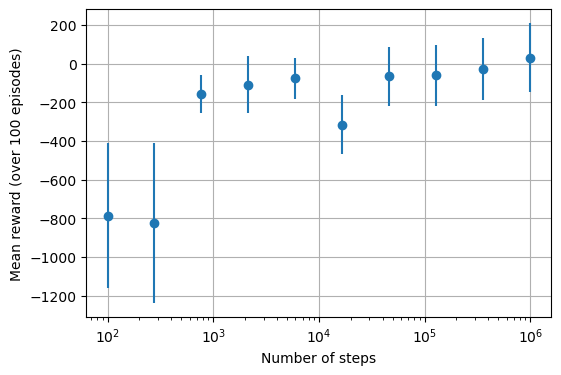

In [34]:
# plot results
plt.figure(figsize=(6, 4))
plt.errorbar(results.keys(), [r[0] for r in results.values()], yerr=[r[1] for r in results.values()], fmt='o')
plt.xscale('log')
plt.xlabel('Number of steps')
plt.ylabel('Mean reward (over 100 episodes)')
plt.grid()
plt.savefig('dqn_lunarlander_reward.png', dpi=300)

MovieWriter Pillow unavailable; using Pillow instead.


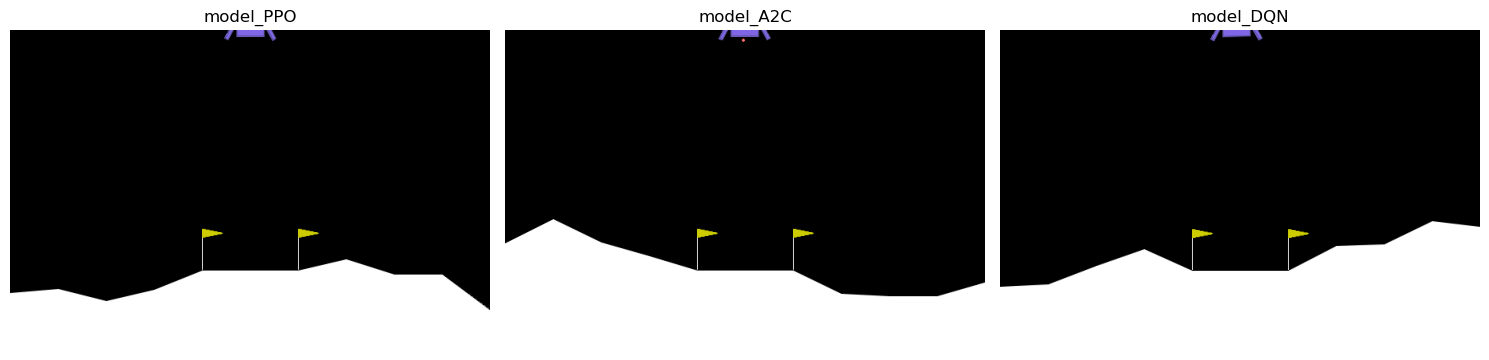

In [38]:
# get list of states
n_frames = 50
show_every = 5
frames = {}

models = ['model_PPO', 'model_A2C', 'model_DQN']

def get_model(model_name):
    if model_name == 'model_PPO':
        model = PPO.load("models/ppo_lunarlander")

    elif model_name == 'model_A2C':
        model = A2C.load("models/a2c_lunarlander")

    elif model_name == 'model_DQN':
        model = DQN.load("models/dqn_lunarlander")

    return model

for model_name in models:
    frames[model_name] = []
    model = get_model(model_name)
    state, _ = eval_env.reset()
    for i in range(n_frames*show_every):
        
        action, _ = model.predict(state, deterministic=True)
        state, _, _, _, _= eval_env.step(action)
        if i % show_every == 0:
            frames[model_name].append(eval_env.render())

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
from matplotlib import animation
from IPython.display import HTML


def animate(i):
    print(i/n_frames, end='\r')
    for axi, model_name in zip(ax, models):
        axi.imshow(frames[model_name][i])
        axi.set_title(model_name)
        axi.set_axis_off()
    fig.tight_layout()
    return fig

anim = animation.FuncAnimation(fig, animate, frames=n_frames, )
anim.save('lunar_lander.gif', writer='Pillow', fps=30)
    


In [ ]:
len(frames['model_PPO'])

200